# Basic (MLP) Adversarial Autoencoder Tutorial


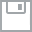
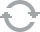
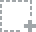
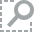
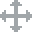
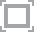
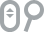
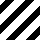
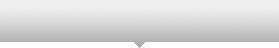
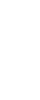
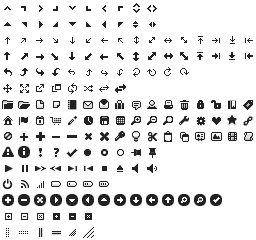
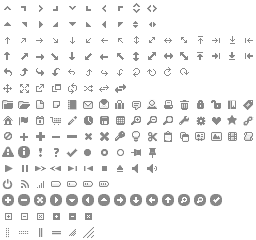
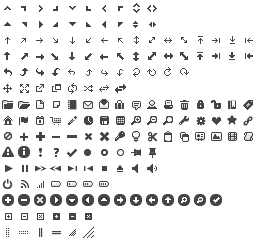
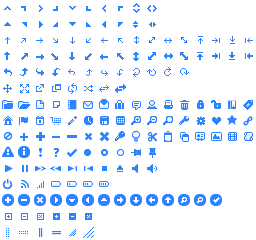
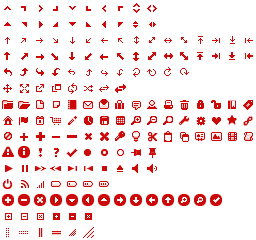
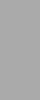
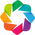
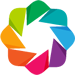

In [1]:
from bokeh.plotting import output_notebook, show
output_notebook()

### On github?
To be able to see (and interact with) the bokeh plotting: Click the round icon in the upper right corner to view the notebook in nbviewer.

In [2]:
import numpy as np
import theano

from theano import tensor
from theano.sandbox.rng_mrg import MRG_RandomStreams

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled)


In [3]:
seed = 123
np.random.seed(seed=seed)
symbolic_rng = MRG_RandomStreams(seed=seed)

## Create a datastream with MNIST

In [4]:
from fuel.datasets import MNIST
from fuel.streams import DataStream
from fuel.schemes import ShuffledScheme
from fuel.transformers import Flatten, ScaleAndShift

dataset = MNIST(('train',))

batch_size = 1000
data_stream_raw = DataStream.default_stream(
    dataset=dataset,
    iteration_scheme=ShuffledScheme(
        examples=dataset.num_examples,
        batch_size=batch_size  # NOTE dataset.num_examples % batch_size should be 0.
    )
)

dataset.num_examples, data_stream_raw.sources

(60000, (u'features', u'targets'))

In [6]:
from adversarial_autoencoder.visualization import plot_image_batch

epoch = data_stream_raw.get_epoch_iterator(as_dict=True)
source_to_batch = next(epoch)

fig = plot_image_batch(source_to_batch['features'], nrows=10, ncols=10, size=400)
show(fig)

### Apply flatten and normalize [-1, 1] images

In [7]:
data_stream_flat = Flatten(
    data_stream_raw,
    which_sources=['features']
)
data_stream_flat_normalized = ScaleAndShift(
    data_stream_flat,
    which_sources=['features'],
    scale=2.0,
    shift=-1.0
)

In [8]:
epoch = data_stream_flat_normalized.get_epoch_iterator(as_dict=True)
source_to_batch = next(epoch)
features = source_to_batch['features']
features.min(), features.max(), features.shape

(-1.0, 1.0, (1000, 784))

## Define NNet components

In [9]:
from blocks.bricks import MLP, Rectifier, Tanh, Logistic, Identity
from blocks.initialization import IsotropicGaussian, Constant

dims = [28*28, 256, 128, 32, 2]  # Lets go down to 2D.

encoder = MLP(
    name='encoder',
    activations=[Rectifier() for dim in dims[1:-1]] + [Identity()],
    dims=dims,
    weights_init=IsotropicGaussian(0.01),
    biases_init=Constant(0.0)
)
encoder.initialize()

decoder = MLP(
    name='decoder',
    activations=[Rectifier() for dim in dims[1:-1]] + [Tanh()],
    dims=dims[::-1],
    weights_init=IsotropicGaussian(0.01),
    biases_init=Constant(0.0)
)
decoder.initialize()

adversarial_predictor = MLP(
    name='adversarial_predictor',
    activations=[Rectifier(), Rectifier(), Logistic()],
    dims=[28*28, 256, 128, 1],
    weights_init=IsotropicGaussian(0.01),
    biases_init=Constant(0.0)
)
adversarial_predictor.initialize()

### Reconstruction Cost

In [10]:
from blocks.bricks.cost import SquaredError

data = tensor.matrix('features')

data_encoded = encoder.apply(data)  # 'data' as opposed to 'prior'
data_decoded = decoder.apply(data_encoded)

cost_reconstruction = SquaredError().apply(
    data,
    data_decoded
)
cost_reconstruction.name = 'cost_reconstruction'

### Adversarial Cost

In [11]:
from blocks.bricks.cost import BinaryCrossEntropy

prior = symbolic_rng.normal(data_encoded.shape)  # We set the prior distribution to be 2D gaussian.
prior_decoded = decoder.apply(prior)

adversarial_input = tensor.concatenate(
    [data_decoded, prior_decoded],
    axis=0
)
adversarial_prediction = adversarial_predictor.apply(
    adversarial_input
)
data_target = tensor.zeros((data.shape[0], 1))  # 'negative' examples
prior_target = tensor.ones((prior.shape[0], 1))  # 'positive' examples
adversarial_target = tensor.concatenate([data_target, prior_target])

cost_adversarial = BinaryCrossEntropy().apply(
    adversarial_target,
    adversarial_prediction
)
cost_adversarial.name = 'cost_adversarial'

### Confusion Cost

In [12]:
adversarial_prior_prediction = adversarial_predictor.apply(
    prior_decoded
)
cost_confusion_factor = 30.0 # TODO there are better methods for weighting
cost_confusion = BinaryCrossEntropy().apply(
    tensor.zeros((prior.shape[0], 1)),  # 'negative' examples, make it belive it is part of data distribution
    adversarial_prior_prediction
) * cost_confusion_factor
cost_confusion.name = 'cost_confusion'

### Cost Autoencoder

In [13]:
cost_autoencoder = cost_reconstruction + cost_confusion # TODO there are better methods for weighting
cost_autoencoder.name = 'cost_autoencoder'

### Computational Graphs and Training Algorithms

In [14]:
from blocks.graph import ComputationGraph
from blocks.algorithms import GradientDescent, AdaDelta

cg_reconstruction = ComputationGraph(cost_reconstruction)

algorithm_autoencoder = GradientDescent(
    cost=cost_autoencoder,
    step_rule=AdaDelta(),
    parameters=cg_reconstruction.parameters,
    # NOTE important that we only optimise with respect to encoding/decoding
    # parameters and consider parameters of adversarial nnet fixed. This is why
    # the computation graph for cost_recostruction is used and not for 
    # cost_autoencoder
    on_unused_sources='warn'
)


cg_adversarial = ComputationGraph(cost_adversarial)

from blocks.filter import VariableFilter

vf = VariableFilter(bricks=adversarial_predictor.children)
adversarial_parameters = vf(cg_adversarial.parameters)
# NOTE the computation graph for cost_adversarial includes the encoder and
# decoder, thus we need to filter out only the parameters for the adversarial
# predictor only (there are other ways this can be done).

algorithm_adversarial = GradientDescent(
    cost=cost_adversarial,
    step_rule=AdaDelta(),
    parameters=adversarial_parameters,
    on_unused_sources='warn'
)

## Define the Main Loop for Training

In [14]:
from blocks.main_loop import MainLoop
from blocks.extensions import Printing, FinishAfter
from blocks.extensions.monitoring import TrainingDataMonitoring

from adversarial_autoencoder.algorithm import SequentialTrainingAlgorithm
from adversarial_autoencoder.monitoring import SequentialTrainingDataMonitoring

from blocks_extras.extensions.embed_ipython import EmbedIPython
from blocks_extras.extensions.plot import Plot

monitor_kwargs = {'every_n_epochs': 1} # update freq of logging and plotting of training progress 

main_loop = MainLoop(
    algorithm=SequentialTrainingAlgorithm(
        algorithm_steps=[
            algorithm_adversarial,
            algorithm_autoencoder
        ]
    ),
    data_stream=data_stream_flat_normalized,
    extensions=[
        SequentialTrainingDataMonitoring(
            training_data_monitoring_steps=[
                TrainingDataMonitoring(
                    variables=[cost_adversarial],
                    **monitor_kwargs
                ),
                TrainingDataMonitoring(
                    variables=[
                        cost_autoencoder,
                        cost_reconstruction,
                        cost_confusion
                    ],
                    **monitor_kwargs
                )
            ],
            **monitor_kwargs
        ),
        Printing(after_epoch=False, every_n_epochs=10),
        EmbedIPython(),
        Plot(
            document='Adversarial Autoencoder (MLP based)',
            channels=[
                [cost_adversarial.name],
                [cost_autoencoder.name, cost_reconstruction.name, cost_confusion.name]
            ],
            #start_server=True,  # monitoring avaliable from localhost:5006
            server_url='http://192.168.1.147:5010/',
            **monitor_kwargs
        ),
        FinishAfter(after_n_epochs=100)
    ]
)

Using saved session configuration for http://192.168.1.147:5010/
To override, pass 'load_from_config=False' to Session


In [15]:
main_loop.run()


-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 resumed_from: None
	 training_started: True
Log records from the iteration 0:


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 10
	 iterations_done: 600
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 600:
	 cost_adversarial: 0.658510029316
	 cost_autoencoder: 190.945373535
	 cost_confusion: 22.6106967926
	 cost_reconstruction:

## Save/Load parameters

In [15]:
from blocks.model import Model

model = Model(cost_adversarial)

### Save

from cPickle import dump

parameters = model.get_parameter_values()
parameters.keys()

with open('parameters.pkl', 'w') as f:
    dump(parameters, f)

### Load

In [16]:
from cPickle import load

with open('parameters.pkl', 'r') as f:
    parameters = load(f)

model.set_parameter_values(parameters)

## Have a look at performance

### Reconstruction

In [17]:
reconstruct_f = theano.function(
    inputs=[data],
    outputs=data_decoded
)

In [18]:
epoch = data_stream_flat_normalized.get_epoch_iterator(as_dict=True)
source_to_batch = next(epoch)
images = source_to_batch['features'].reshape(1000,1,28,28)
images_reconstructed = reconstruct_f(source_to_batch['features']).reshape(1000,1,28,28)

fig_original = plot_image_batch(images, nrows=5, ncols=5, size=400)
fig_reconstructed = plot_image_batch(images_reconstructed, nrows=5, ncols=5, size=400)

show(fig_original)
show(fig_reconstructed)

### Try sampling from prior

In [22]:
decode_f = theano.function(
    inputs=[data_encoded],
    outputs=data_decoded,
    allow_input_downcast=True
)

In [24]:
prior = np.random.randn(25, 2)
prior_images = decode_f(prior).reshape(25, 1, 28, 28)

fig_prior = plot_image_batch(prior_images, nrows=5, ncols=5, size=400)
show(fig_prior)

#### We should try to continue training to get rid of artifacts...

## Check where the data ends up in 2D

In [25]:
encode_f = theano.function(
    inputs=[data],
    outputs=data_encoded
)

In [69]:
source_to_batches = [next(epoch) for i in range(10)]
targets, features = map(
    np.concatenate,
    zip(
        *[
            (source_to_batch['targets'], source_to_batch['features'])
            for source_to_batch in source_to_batches
        ]
    )
)
features_encoded = encode_f(features)

In [72]:
import pandas as pd

df = pd.DataFrame(
    data=np.concatenate([targets, features_encoded], axis=1).astype(float),
    columns=['label', 'x', 'y']
)
df.head()

,label,x,y
0,3,-19.339706,-2.852407
1,0,-18.503580,1.677715
2,4,-0.267391,-0.304680
3,0,-15.745543,1.547022
4,3,-0.979802,0.558564


In [76]:
from bokeh.charts import Scatter
from bokeh.models import Range1d

fig_scatter = Scatter(df,  x='x', y='y', color='label', legend='top_left')
fig_scatter.x_range = Range1d(-3, 3)
fig_scatter.y_range = Range1d(-3, 3)
fig_scatter.plot_width = 800
fig_scatter.plot_height = 600
show(fig_scatter)

### not really gaussian...

In [58]:
# TODO better colors